https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

f(x) = x * sin(x)

In [2]:
X = np.linspace(start=0, stop=10, num=1_000).reshape(-1, 1)
y = np.squeeze(X * np.sin(X))

Text(0, 0.5, '$f(x)$')

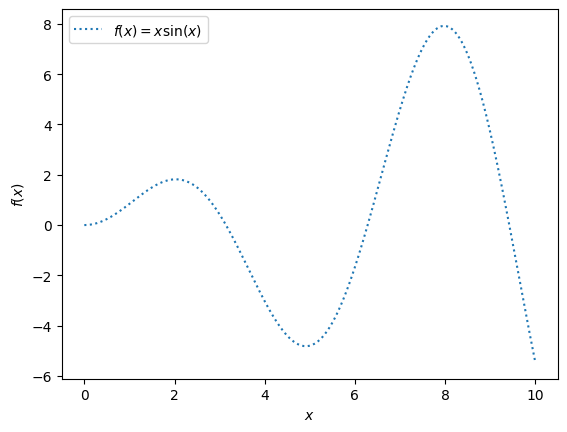

In [3]:
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

In [4]:
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=6, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

In [21]:
X_train

array([[5.07507508],
       [8.18818819],
       [4.52452452],
       [3.68368368],
       [2.42242242],
       [9.2992993 ]])

In [6]:
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

5.02**2 * RBF(length_scale=1.43)

Text(0, 0.5, '$f(x)$')

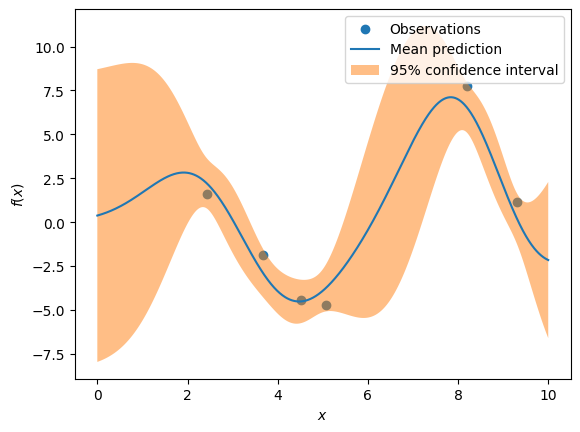

In [22]:
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

In [8]:
noise_std = 0.75
y_train_noisy = y_train + rng.normal(loc=0.0, scale=noise_std, size=y_train.shape)

In [9]:
gaussian_process = GaussianProcessRegressor(
    kernel=kernel, alpha=noise_std**2, n_restarts_optimizer=9
)
gaussian_process.fit(X_train, y_train_noisy)
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

Text(0, 0.5, '$f(x)$')

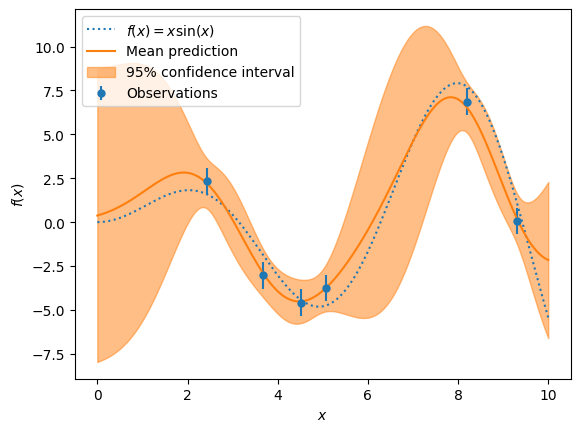

In [10]:
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.errorbar(
    X_train,
    y_train_noisy,
    noise_std,
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations",
)
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

https://domino.ai/blog/fitting-gaussian-process-models-python#body__5b6ea80717d6

In [11]:
'''
1. choose a patient
2. perform the same percentile calculation
3. put in data session by session
'''

In [14]:
import pandas as pd
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib_venn as venn
from helper import *
import ipywidgets as widgets

In [15]:
from connection import *

con = connect()
df = SQL("select * from constant_therapy.q3", con)

Connection Successful


In [18]:
data = df[df.patient_id == 148635]
data

,patient_id,session_id,type,parent_id,schedule_id,start_time,start_time_min,end_time,end_time_min,total_exercises,duration,domain_id,progression_order,task_type_id,task_level,accuracy,latency
21970,153775,9446572,SCHEDULED,9446571,466010,2017-12-17,2017-12-17 01:50:20,2017-12-17,2017-12-17 01:50:54,3,30.0,6,13,1,1,0.333,10.16
21972,153775,9446635,SCHEDULED,9446634,466010,2017-12-17,2017-12-17 02:05:39,2017-12-17,2017-12-17 02:06:05,3,19.0,6,13,1,1,0.667,6.65
21974,153775,9446754,SCHEDULED,9446750,466509,2017-12-17,2017-12-17 02:53:42,2017-12-17,2017-12-17 02:55:52,10,79.0,6,13,1,1,0.701,7.95
21981,153775,9448115,SCHEDULED,9448111,466509,2017-12-17,2017-12-17 15:14:23,2017-12-17,2017-12-17 15:19:35,10,73.0,6,13,1,1,0.700,7.38
21990,153775,9448416,SCHEDULED,9448412,466509,2017-12-17,2017-12-17 15:44:02,2017-12-17,2017-12-17 15:47:15,10,176.0,6,13,1,1,0.700,17.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4667326,153775,25204212,SCHEDULED,25204206,1615746,2020-06-30,2020-06-30 18:45:02,2020-06-30,2020-06-30 18:46:33,5,33.0,4,4,165,1,1.000,6.80
4668053,153775,25282941,SCHEDULED,25282934,1615746,2020-07-06,2020-07-06 15:54:17,2020-07-06,2020-07-06 15:55:29,5,46.0,5,2,165,1,1.000,9.28
4668054,153775,25282941,SCHEDULED,25282934,1615746,2020-07-06,2020-07-06 15:54:17,2020-07-06,2020-07-06 15:55:29,5,46.0,4,4,165,1,1.000,9.28
4668131,153775,25298775,SCHEDULED,25298769,1615746,2020-07-07,2020-07-07 15:12:22,2020-07-07,2020-07-07 15:13:12,5,39.0,5,2,165,1,1.000,7.89


In [19]:
data = data.sort_values(by="end_time_min")